# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 5 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh

https://drive.google.com/open?id=18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv

https://drive.google.com/open?id=1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz

https://drive.google.com/open?id=1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a

https://drive.google.com/open?id=1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ

In [52]:
from google.colab import drive
drive.mount('/content/drive')
import os
CUDA_LAUNCH_BLOCKING=1

Mounted at /content/drive


In [0]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [54]:
from google.colab import drive
drive.mount('/content/drive')
import h5py 
from torchsummary import summary
import torch
import cv2
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from google.colab import drive
from torch.utils.data import Dataset, DataLoader

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW3b')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)
print(HOMEWORK_FOLDER)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh': 'hw3_mycocodata_bboxes_comp_zlib.npy',
'18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv': 'hw3_mycocodata_img_comp_zlib.h5',
'1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz': 'hw3_mycocodata_labels_comp_zlib.npy',
'1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a': 'hw3_mycocodata_mask_comp_zlib.h5',
'1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ': 'checkpoint680.pth',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

Mounted at /content/gdrive
/content/gdrive/My Drive/CIS680_2019/HW3b


# Functions


In [0]:
def do_for(fn, mat):
    return np.apply_along_axis(fn, 1, mat)

def rev(tup):
    """Reverses a tuple"""
    return tup[::-1]  


def t_param_to_topleft_topright(t_x, t_y, t_w, t_h,x,y,x2,y2):
  x_a, y_a = compute_center([x,y,x2-x, y2-y])
  xval = t_x*(x2-x) + x_a
  yval = t_y*(y2-y) + y_a
  wval = np.exp(t_w)*(x2-x)
  hval = np.exp(t_h)*(y2-y)
  transformed = [xval - wval/2,yval - hval/2,xval + wval/2,yval + hval/2]
  return transformed

def display_list_of_boxes(image, list_of_boxes, wh = True):
  
  plt.imshow(image)
  ax = plt.gca()

  for i in range(len(list_of_boxes)):
         
      box_values = list_of_boxes[i]

      if not wh:
        x, y, x2, y2 = box_values
        w = x2-x
        h = y2-y
      else:
        x, y, w, h = box_values
        
      rect = Rectangle((x, y), w, h, fill=False, linewidth=3)

      ax.add_patch(rect)

plt.show()

"""Given top left and bottom right corners, returns the center"""
def compute_center(vals):
  x1,y1,w,h = vals
  middle_x = x1 + (w)/2
  middle_y = y1 + (h)/2
  return middle_x,middle_y

def convert_image(img):
  a = _resize(img, (1066,800))
  img = pad_along_axis(a,11)
  mean=[0.485, 0.456, 0.406]     
  std=[0.229, 0.224, 0.225]
  img[0,:,:] = ((img[0,:,:]/255)-mean[0])/(std[0])
  img[1,:,:] = ((img[1,:,:]/255)-mean[1])/(std[1])
  img[2,:,:] = ((img[2,:,:]/255)-mean[2])/(std[2])
  return img

def convert_bboxes(bboxes):
  temp = []
  for i in range(bboxes.shape[0]):
    x1,y1,x2,y2 = bboxes[i] 
    w_ratio = 800/300
    h_ratio = 1088/400
    newbox = int(w_ratio*x1)+11, int(h_ratio*y1), int(w_ratio*x2)+11, int(h_ratio*y2)
    temp.append(newbox)
  return np.array(temp)

def convert_masks(masks):
  total = []
  for mask in masks:
    new = _resize_mask(mask, (1066,800))
    padded = pad_along_axis(new,11)
    total.append(padded)
  return np.array(total)
  

def _resize(img, output_shape):
    """Resize a channels-first image with bilinear interpolation to output shape

    Inputs:
        img: a channels first image (CH, H, W)
        output_shape: tuple(W, H)

    Outputs: Resized channels-first image with output shape
    """
    now = cv2.resize(
        img.transpose((1,2,0)).astype(np.uint8),
        output_shape,
        interpolation=cv2.INTER_LINEAR).transpose((2,0,1))
    return now

def _resize_mask(mask, output_shape):
  
    if (len(mask.shape) == 3):
        return cv2.resize(
            mask.astype(np.uint8),
            output_shape,
            interpolation=cv2.INTER_NEAREST)     
    else:
        return cv2.resize(
            mask.astype(np.uint8),
            output_shape,
            interpolation=cv2.INTER_NEAREST)                

COLORS = {
    1: [255, 0, 0], # Vehicle
    2: [0, 0, 255], # Animals
    3: [0, 255, 0] # People
}

def show(img):
    """Show a channels-first image"""
    plt.figure()
    plt.imshow(img.transpose(1,2,0))

def show_img(images, bboxes, labels, only_one):
    show(_draw_bounding_boxes(
            images, 
            bboxes,
            labels))

def show_mask(masks, image, labels, only_one):
    # We need to use mask indices
    if len(masks.shape) == 2:
        masks = np.expand_dims(masks, 0)

    show(_draw_mask(
            image, 
            masks,
            labels, only_one))

def show_both(image, bboxes, masks, labels, only_one):
    show_img(image, bboxes, labels, only_one)
    show_mask(masks, image, labels, only_one)

def _draw_bounding_boxes(image, bboxes, labels, only_one = True):
    """Draw bounding boxes onto channels-first image. Returns copy of image."""
    ret_copy = image.transpose((1,2,0)).copy()
    
    if only_one: 
      c1 = tuple(bboxes[:2].astype(int))
      c2 = tuple(bboxes[2:].astype(int))
      cv2.rectangle(ret_copy, c1, c2, COLORS[labels], 4)
    else:
      for idx in range(labels.shape[0]):
        c1 = tuple(bboxes[idx, :2].astype(int))
        c2 = tuple(bboxes[idx, 2:].astype(int))
        cv2.rectangle(ret_copy, c1, c2, COLORS[labels[idx]], 4)

    return ret_copy.transpose((2,0,1))
  
def _draw_mask(image, masks, labels, only_one = True):

    ret_copy = image.copy()
    
    if only_one:
      color = COLORS[labels]
      mask = (masks > 0)
      ret_copy = ret_copy.transpose((1,2,0))
      ret_copy[mask[0],:] = np.array(color)
      ret_copy = ret_copy.transpose((2,0,1))

    else:

      for idx in range(labels.shape[0]):
          color = COLORS[labels[idx]]
          mask = (masks[idx] > 0)
          ret_copy = ret_copy.transpose((1,2,0))
          ret_copy[mask,:] = np.array(color)
          ret_copy = ret_copy.transpose((2,0,1))

    return ret_copy

In [0]:
def pad_along_axis(array, target_length, axis=1):
    if array.shape[0] == 3:
      new = np.array(np.zeros((3,800,1088)))
    else:
      new = np.array(np.zeros((800,1088)))

    if array.shape[0] == 3:
      for i in range(array.shape[0]):
        new[i,:,11:1077] = array[i]
        new[i,:,0:11]=0
        new[i,:,1077:1088] = 0
    else:
      new[:,11:1077] = array
      new[:,0:11]=0
      new[:,1077:1088] = 0
    return new

# Load Checkpoint
Here is some sample code to load the pretrained model we are providing

In [0]:
import torchvision
import torch

def pretrained_model_680(checkpoint_file):

    import torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
    
    model.eval()
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    backbone = model.backbone
    rpn = model.rpn
    
    checkpoint = torch.load(checkpoint_file)
    
    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])
    
    return backbone, rpn


backbone,rpn = pretrained_model_680('checkpoint680.pth')


E = torch.ones([2,3,800,1088], device='cuda')
#backout = backbone(E)
#theinput = backout[0]

#from torchvision.models.detection.image_list import ImageList 
#im_lis = ImageList(E, [(800,1088),(800,1088)])

#rpn.eval()
#rpnout = rpn(im_lis,backout)
#print(rpnout[0][0].shape)
#test = torchvision.ops.roi_align(theinput, rpnout[0][0], (7,7), spatial_scale=1.0, sampling_ratio=-1)


#print(test.shape)

# PyTorch Dataset

Copy your HW3a dataset code

In [0]:
from torchvision import transforms
class HW3Dataset(torch.utils.data.Dataset):
  def __init__(self):
    
    bbox_path = 'hw3_mycocodata_bboxes_comp_zlib.npy'
    
    images_path = 'hw3_mycocodata_img_comp_zlib.h5'
    
    labels_path = 'hw3_mycocodata_labels_comp_zlib.npy'
    
    masks_path = 'hw3_mycocodata_mask_comp_zlib.h5'
    
    self.bboxes = np.load(bbox_path, allow_pickle=True, encoding='bytes')
    self.labels = np.load(labels_path, allow_pickle=True, encoding='bytes')
    
    self.masks = h5py.File(masks_path, 'r')['data']
    self.images = h5py.File(images_path, 'r')['data']
    self.mask_indices = np.cumsum([len(l) for l in self.labels])


  def __len__(self):
    return self.images.shape[0]
   
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    if idx == 0:
      masks = self.masks[:self.mask_indices[0]]
    else:
      masks = self.masks[self.mask_indices[idx-1]:self.mask_indices[idx]]

    batch = {
        'index': idx,
        'images': self.images[idx].astype('float'),
        'labels': self.labels[idx].astype('float'),
        'bboxes': self.bboxes[idx].astype('float'),
        'masks': convert_masks(masks)
    }
    
    return batch

In [0]:
from torch.nn.utils.rnn import pad_packed_sequence, pack_sequence

def my_collate(batch):
  
    images = [torch.from_numpy(convert_image(item['images'])) for item in batch] #.type(torch.FloatTensor)
    labels = [torch.from_numpy(item['labels']) for item in batch]
    bboxes = [torch.from_numpy(convert_bboxes(np.asarray(item['bboxes']))).type(torch.FloatTensor) for item in batch]
    masks = [torch.from_numpy(item['masks']).type(torch.FloatTensor) for item in batch]

    images = torch.stack(images)

    bboxes = pack_sequence(bboxes, enforce_sorted=False)
    padded_seq_bboxes, length = pad_packed_sequence(bboxes, batch_first = True, padding_value = -1)
    
    labels = pack_sequence(labels, enforce_sorted=False)
    
    padded_seq_labels, length = pad_packed_sequence(labels, batch_first = True, padding_value = -1)

    masks = pack_sequence(masks, enforce_sorted=False)
    padded_seq_masks, length = pad_packed_sequence(masks, batch_first = True, padding_value = -1) 
        
    return images,padded_seq_masks, padded_seq_labels, padded_seq_bboxes

In [61]:
use_gpu = torch.cuda.is_available()
print(use_gpu)
cuda = torch.device('cuda')
y = torch.tensor([1., 2.], device='cuda')
import pdb

CUDA_LAUNCH_BLOCKING=1

True


In [0]:
dataset = HW3Dataset()


In [0]:
def bbox_iou(box1, box2):

  b1_x1, b1_y1, b1_w, b1_h = box1[0], box1[1], box1[2], box1[3]
  b2_x1, b2_y1, b2_w, b2_h = box2[0], box2[1], box2[2], box2[3]
  

  b1_x2, b1_y2 = b1_x1 + b1_w,  b1_y1 + b1_h
  b2_x2, b2_y2 = b2_x1 + b2_w,  b2_y1 + b2_h

  intersectionx1 =  torch.max(torch.tensor(b1_x1), torch.tensor(b2_x1))
  intersectiony1 =  torch.max(torch.tensor(b1_y1), torch.tensor(b2_y1))
  intersectionx2 =  torch.min(torch.tensor(b1_x2), torch.tensor(b2_x2))
  intersectiony2 =  torch.min(torch.tensor(b1_y2), torch.tensor(b2_y2))

  inter_area = torch.clamp(intersectionx2 - intersectionx1 + 1, min=0) * torch.clamp( intersectiony2 -  intersectiony1 + 1, min=0)

  b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
  b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)

  iou = inter_area.type(torch.FloatTensor) / (b1_area + b2_area - inter_area).type(torch.FloatTensor)

  return iou

In [0]:
def ratio_iou(x1, y1, x2, y2, x1_a, y1_a, x2_a, y2_a, eps=1e-5):
    xi = torch.max(x1, x1_a)                                 # Intersection
    yi = torch.max(y1, y1_a)
    wi = torch.clamp(torch.min(x1+(x2-x1), x1_a+(x2_a-x1_a))-xi, min=0)
    hi = torch.clamp(torch.min(y1+(y2-y1), y1_a+(y2_a-y1_a))-yi, min=0)
    area_i = wi * hi                                       # Area Intersection
    area_u = (x2-x1) * (y2-y1) + (x2_a-x1_a) * (y2_a-y1_a) - wi * hi                   # Area Union
    return area_i / torch.clamp(area_u, min=eps)

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(12544,6000)
        self.fc2 = nn.Linear(6000,1024)
        self.fc3 = nn.Linear(1024,4)
        self.fc4 = nn.Linear(1024,16)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        classification = F.softmax(self.fc3(x))
        regression = self.fc4(x)
        return classification,regression

In [0]:
from timeit import default_timer as timer

In [0]:
net = MLP()
net = net.cuda()
model_path = os.path.join(HOMEWORK_FOLDER, 'model_maskrcnn_full11')
info_path = os.path.join(HOMEWORK_FOLDER, 'training_info_maskrcnn_full111')

if os.path.isfile(model_path):
  #info = torch.load(info_path)
  a = torch.load(model_path)
  #net.load_state_dict(torch.load(model_path))
  #epoch_curr = info['epoch'][-1] + 1

In [0]:
def get_t_16():
  list_of_gt_classes.extend([gt_label[i][g] for j in range(paramed[0].shape[0])])
  for j in t_x.shape[0]:
    long_tensor = torch.zeros(16)
    long_tenor[gt_label[i][g]*4:gt_label[i][g]*4+4] = torch.tensor([t_x[j], t_y[j], t_w[j], t_h[j]])


In [0]:
full_dataset = HW3Dataset()
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [118]:
from torchvision.models.detection.image_list import ImageList 

model_path = os.path.join(HOMEWORK_FOLDER, 'model_final2')
info_path = os.path.join(HOMEWORK_FOLDER, 'info_final2')

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, collate_fn = my_collate)
net = MLP()
net = net.cuda()
criterion = torch.nn.CrossEntropyLoss()
criterion2 = torch.nn.L1Loss()
learning_rate = (10e-3)/8
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
num_epochs = 5

info = {
      'epoch': [],
      'total_loss': [],
      'classification_loss': [],
      'regression_loss': [],
      'running_classification_loss': [],
      'running_regression_loss': [],
      'loss': [],
      'learning_rate': [],
  }

if os.path.isfile(model_path):
  print("Yes")
  info = torch.load(info_path)
  net.load_state_dict(torch.load(model_path))
  epoch_curr = info['epoch'][-1] + 1
  
else:
  epoch_curr = 0

for epoch in epoch_curr, num_epochs:
  print(epoch, "epoch")
  running_loss = 0
  running_classification = 0 
  running_regression = 0
  for elem_index, elem in enumerate(train_dataloader):
    start = timer()
    all_images_list_of_featuremaps = []
    all_images_list_of_boundingboxes = []
    all_images_list_of_boundingboxes_background = []
    all_images_list_of_gt_masks = []
    all_images_list_of_t_params = []
    all_images_list_of_gt_classes = []

    all_images_list_of_gt_boundingboxes = []

    #print(timer()-start)
    if torch.cuda.is_available():
      x = elem[0].cuda()
      gt_mask = elem[1]
      gt_label = elem[2]
      gt_boxes = elem[3].cuda()
      

      backout = backbone(x.float())
      im_lis = ImageList(x, [(800,1088)]*elem[0].shape[0])
      rpn.eval()
      rpnout = rpn(im_lis,backout)

      for param in backbone.parameters():
        param.requires_grad=False

      for param in rpn.parameters():
        param.requires_Grad=False

      """ i is responsible for which image of the batch"""
      for i in range(len(rpnout[0])):

        list_of_boundingboxes = []
        list_of_gt_masks = []
        list_of_gt_boundingboxes = []
        list_of_gt_classes = []
        list_of_t_params = []

        list_of_boundingboxes_background = []
        list_of_gt_masks_background = []
        list_of_gt_boundingboxes_background = []

        current_batch = rpnout[0][i]

        x1 = current_batch[:,0]
        y1 = current_batch[:,1]
        x2 = current_batch[:,2]
        y2 = current_batch[:,3]
        max_iou = 0
        gbox = None
        bestbox = None
        bestbox_mask = None
        bestbox_label = None

        accumulated_tests = [] 
        indexes_of_positives = []

        #g iterates through all the ground truth boxes
        for g in range(elem[3][i].shape[0]):
          if gt_label[i][g] != -1:
            test = ratio_iou(gt_boxes[i][g][0], gt_boxes[i][g][1], gt_boxes[i][g][2], gt_boxes[i][g][3], x1,y1,x2,y2)
            accumulated_tests.append(test)

            vals_x1 = x1[test>0.5].data.cpu()
            vals_y1 = y1[test>0.5].data.cpu()
            vals_x2 = x2[test>0.5].data.cpu()
            vals_y2 = y2[test>0.5].data.cpu()

            allvals = torch.stack([vals_x1,vals_y1,vals_x2,vals_y2])
            allvals_predicted = list(torch.unbind(allvals,axis=1))
            
            middle_x, middle_y = compute_center([vals_x1, vals_y1, vals_x2-vals_x1, vals_y2-vals_y1])

            w = gt_boxes[i][g][2]-gt_boxes[i][g][0]
            h = gt_boxes[i][g][3]-gt_boxes[i][g][1]

            middle_x_gt, middle_y_gt = compute_center([gt_boxes[i][g][0], gt_boxes[i][g][1], w, h])

            t_x = (middle_x_gt-middle_x)/(vals_x2-vals_x1)
            t_y = (middle_y_gt-middle_y)/(vals_y2-vals_y1)

            t_w = np.log(w/(vals_x2-vals_x1).data.cpu())
            t_h = np.log(h/(vals_y2-vals_y1).data.cpu())

            paramed = t_param_to_topleft_topright(t_x, t_y, t_w, t_h,vals_x1,vals_y1,vals_x2,vals_y2)
            
            boxes_predicted = torch.unbind(torch.stack(paramed),axis=1)
            #display_list_of_boxes(elem[0][0].permute(1,2,0),boxes_predicted, wh = False)
            
            gt_list = [gt_boxes[i][g].cuda() for j in range(paramed[0].shape[0])]
            

            list_of_gt_classes.extend([gt_label[i][g] for j in range(paramed[0].shape[0])])
            t_values = [torch.tensor([t_x[j], t_y[j], t_w[j], t_h[j]]).cuda() for j in range(t_x.shape[0])]

            list_of_t_params.extend(t_values)
            list_of_gt_boundingboxes.extend(gt_list)


            stacked_bboxes = torch.stack([vals_x1, vals_y1, vals_x2, vals_y2])
            stacked_bboxes = list(torch.unbind(stacked_bboxes,axis=1))
            list_of_boundingboxes.extend(stacked_bboxes)

            list_of_gt_masks.extend([gt_mask[i][g] for j in range(paramed[0].shape[0])])
            

            #print("hi", len(list_of_boundingboxes), len(list_of_t_params), list_of_boundingboxes[0].shape, list_of_t_params[0].shape, "bye")
            
            if x1[test>0.5].shape[0] == 0:
              index = torch.where(test==torch.max(test).data)[0]
              val_x1 = x1[index].data.cpu()
              val_y1 = y1[index].data.cpu()
              val_x2 = x2[index].data.cpu()
              val_y2 = y2[index].data.cpu()
              middle_x, middle_y = compute_center([val_x1, val_y1, val_x2-val_x1, val_y2-val_y1])

              allvals_predicted = torch.tensor([vals_x1,vals_y1,vals_x2,vals_y2])
              list_of_t_params.append(allvals_predicted)

              t_x = (middle_x_gt-middle_x)/(val_x2-val_x1)
              t_y = (middle_y_gt-middle_y)/(val_y2-val_y1)

              t_w = np.log(w/(val_x2-val_x1).data.cpu())
              t_h = np.log(h/(val_y2-val_y1).data.cpu())

              t_values = torch.tensor([t_x, t_y, t_w, t_h])
              list_of_t_params.append(t_values)

              list_of_gt_boundingboxes.append(gt_boxes[i][g])
              
              list_of_gt_masks.append(gt_mask[i][g])
              list_of_gt_classes.append(gt_label[i][g])  
      
        """Now for background"""
        
        a = torch.stack(accumulated_tests)
        maxval = torch.max(a, dim=0)[0]
        vals_x1 = x1[maxval<0.5].data.cpu()
        vals_y1 = y1[maxval<0.5].data.cpu()
        vals_x2 = x2[maxval<0.5].data.cpu()
        vals_y2 = y2[maxval<0.5].data.cpu()
        
        stacked_bboxes = torch.stack([vals_x1, vals_y1, vals_x2, vals_y2])
        list_of_boundingboxes_background.extend(list(torch.unbind(stacked_bboxes,axis=1)))

        """Getting positives and negatives"""

        top_20_bboxes = list_of_boundingboxes
        number_of_positives = len(list_of_boundingboxes)

        if number_of_positives < 70:
          #top_bboxes = list_of_boundingboxes
          #top_tparams = list_of_t_params
          #top_gt_bboxes = list_of_gt_boundingboxes
          #top_classes = list_of_gt_classes
          indexes_of_positives.append(len(list_of_boundingboxes))
          background_bboxes = list_of_boundingboxes_background[0:70-len(list_of_boundingboxes)]
          #total_classes_gt_pos.extend(torch.zeros(0:70-len(list_of_boundingboxes)))
          
        else:
           background_bboxes = list_of_boundingboxes

        all_images_list_of_boundingboxes.append(torch.stack(list_of_boundingboxes).cuda()) 
        all_images_list_of_boundingboxes_background.append(torch.stack(background_bboxes).cuda()) 
        all_images_list_of_gt_boundingboxes.append(torch.stack(list_of_gt_boundingboxes).cuda())
    
        all_images_list_of_t_params.append(torch.stack(list_of_t_params).cuda())
        all_images_list_of_gt_classes.append(torch.stack(list_of_gt_classes).cuda())

      """Getting the ROI align for both the background boxes and non-background boxes"""
      test = torchvision.ops.roi_align(backout[0].cuda(), all_images_list_of_boundingboxes, (7,7), spatial_scale=1.0/4.0, sampling_ratio=-1)
      test2 = torchvision.ops.roi_align(backout[0].cuda(), all_images_list_of_boundingboxes_background, (7,7), spatial_scale=1.0/4.0, sampling_ratio=-1)
      total_features = torch.cat([test, test2])
          
      #you dont need to make your own one hot encodings since Cross entropy takes a vector of predictions, and a value of target
      c = total_features.view(total_features.size(0), -1)
      classification, regression = net(c.cuda())
          
      total_t_params = torch.cat(all_images_list_of_t_params)
      total_classes_gt_pos = torch.cat(all_images_list_of_gt_classes)
      
      """classes for background + nonbackground"""
      total_pos_and_neg = torch.cat([total_classes_gt_pos.double(),torch.zeros(70*elem[0].shape[0]-total_classes_gt_pos.shape[0]).double().cuda()])
      optimizer.zero_grad()

      """We only care about the regressions for the non-background boxes"""
      regressed = regression[0:total_classes_gt_pos.shape[0]]

      """indexing into the correct four values for that class"""
      hot_encoding_regressor =  torch.stack([torch.arange(l*4,((l+1)*4)) for l in torch.tensor(total_classes_gt_pos.tolist()).cuda().type(torch.cuda.LongTensor)])
      regressor_bboxes = torch.gather(
            regressed.cuda(), 1, hot_encoding_regressor.type(torch.cuda.LongTensor))

      """getting losses"""           
      regression_loss = criterion2(regressor_bboxes, total_t_params.type(torch.FloatTensor).cuda())
      classification_loss = criterion(classification, total_pos_and_neg.type(torch.LongTensor).cuda())

      loss = classification_loss + regression_loss
    
      loss.backward()   
      running_classification = classification_loss.item()
      running_regression = regression_loss.item()
      running_loss += loss.item()
      info['running_classification_loss'].append(classification_loss.item())
      info['running_regression_loss'].append(regression_loss.item())
      info['loss'].append(loss.item())
      optimizer.step()
      
  torch.save(net.state_dict(), model_path)
  info['epoch'].append(epoch)
  info['total_loss'].append(running_loss)
  info['classification_loss'].append(running_classification)
  info['regression_loss'].append(running_regression)
  info['learning_rate'].append(learning_rate)
  torch.save(info, info_path)


Yes
6 epoch


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


KeyboardInterrupt: ignored

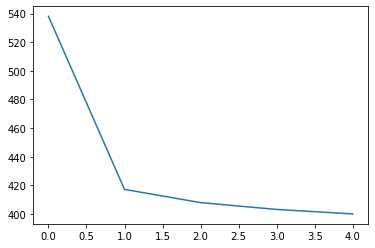

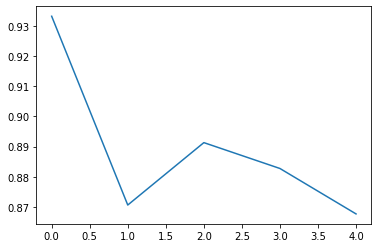

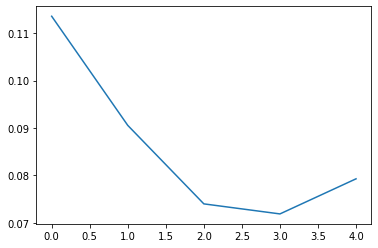

In [0]:
plt.plot(torch.load(HOMEWORK_FOLDER + "/info_final1")['total_loss'])
plt.savefig(HOMEWORK_FOLDER + '/total_loss_1.png')
plt.figure()
plt.plot(torch.load(HOMEWORK_FOLDER + "/info_final1")['classification_loss'])
plt.savefig(HOMEWORK_FOLDER + '/classification_loss_1.png')
plt.figure()
plt.plot(torch.load(HOMEWORK_FOLDER + "/info_final1")['regression_loss'])
plt.savefig(HOMEWORK_FOLDER  + '/regression_loss_1.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([17]) torch.Size([17]) torch.Size([17, 4])


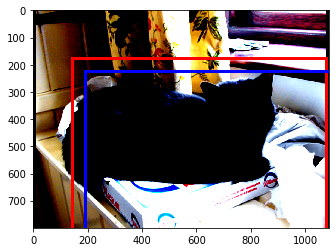

In [131]:
net = MLP().cuda()
net.load_state_dict(torch.load(os.path.join(HOMEWORK_FOLDER,'model_final2')))
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn = my_collate)

for elem_index, elem in enumerate(test_dataloader):
  start = timer()
  all_images_list_of_featuremaps = []
  all_images_list_of_boundingboxes = []
  all_images_list_of_boundingboxes_background = []
  all_images_list_of_gt_masks = []
  all_images_list_of_t_params = []
  all_images_list_of_gt_classes = []

  all_images_list_of_gt_boundingboxes = []

  #print(timer()-start)
  if torch.cuda.is_available():
    x = elem[0].cuda()
    gt_mask = elem[1]
    gt_label = elem[2]
    gt_boxes = elem[3].cuda()
    

    backout = backbone(x.float())
    im_lis = ImageList(x, [(800,1088)]*elem[0].shape[0])
    rpn.eval()
    rpnout = rpn(im_lis,backout)

    for param in backbone.parameters():
      param.requires_grad=False

    for param in rpn.parameters():
      param.requires_Grad=False

  for i in range(len(rpnout[0])):
    list_of_boundingboxes = []
    list_of_gt_masks = []
    list_of_gt_boundingboxes = []
    list_of_gt_classes = []
    list_of_t_params = []

    list_of_boundingboxes_background = []
    list_of_gt_masks_background = []
    list_of_gt_boundingboxes_background = []

    current_batch = rpnout[0][i]

    x1 = current_batch[:,0]
    y1 = current_batch[:,1]
    x2 = current_batch[:,2]
    y2 = current_batch[:,3]
    max_iou = 0
    gbox = None
    bestbox = None
    bestbox_mask = None
    bestbox_label = None

    accumulated_tests = [] 
    indexes_of_positives = []

    #g iterates through all the ground truth boxes
    for g in range(elem[3][i].shape[0]):
      if gt_label[i][g] != -1:
        test = ratio_iou(gt_boxes[i][g][0], gt_boxes[i][g][1], gt_boxes[i][g][2], gt_boxes[i][g][3], x1,y1,x2,y2)
        accumulated_tests.append(test)

        vals_x1 = x1[test>0.5].data.cpu()
        vals_y1 = y1[test>0.5].data.cpu()
        vals_x2 = x2[test>0.5].data.cpu()
        vals_y2 = y2[test>0.5].data.cpu()

        allvals = torch.stack([vals_x1,vals_y1,vals_x2,vals_y2])
        allvals_predicted = list(torch.unbind(allvals,axis=1))
        
        middle_x, middle_y = compute_center([vals_x1, vals_y1, vals_x2-vals_x1, vals_y2-vals_y1])

        w = gt_boxes[i][g][2]-gt_boxes[i][g][0]
        h = gt_boxes[i][g][3]-gt_boxes[i][g][1]

        middle_x_gt, middle_y_gt = compute_center([gt_boxes[i][g][0], gt_boxes[i][g][1], w, h])

        t_x = (middle_x_gt-middle_x)/(vals_x2-vals_x1)
        t_y = (middle_y_gt-middle_y)/(vals_y2-vals_y1)

        t_w = np.log(w/(vals_x2-vals_x1).data.cpu())
        t_h = np.log(h/(vals_y2-vals_y1).data.cpu())

        paramed = t_param_to_topleft_topright(t_x, t_y, t_w, t_h,vals_x1,vals_y1,vals_x2,vals_y2)
        
        boxes_predicted = torch.unbind(torch.stack(paramed),axis=1)
        #display_list_of_boxes(elem[0][0].permute(1,2,0),boxes_predicted, wh = False)
        
        gt_list = [gt_boxes[i][g].cuda() for j in range(paramed[0].shape[0])]
        

        list_of_gt_classes.extend([gt_label[i][g] for j in range(paramed[0].shape[0])])
        t_values = [torch.tensor([t_x[j], t_y[j], t_w[j], t_h[j]]).cuda() for j in range(t_x.shape[0])]

        list_of_t_params.extend(t_values)
        list_of_gt_boundingboxes.extend(gt_list)


        stacked_bboxes = torch.stack([vals_x1, vals_y1, vals_x2, vals_y2])
        stacked_bboxes = list(torch.unbind(stacked_bboxes,axis=1))
        list_of_boundingboxes.extend(stacked_bboxes)

        list_of_gt_masks.extend([gt_mask[i][g] for j in range(paramed[0].shape[0])])
        

        #print("hi", len(list_of_boundingboxes), len(list_of_t_params), list_of_boundingboxes[0].shape, list_of_t_params[0].shape, "bye")
        
        if x1[test>0.5].shape[0] == 0:
          index = torch.where(test==torch.max(test).data)[0]
          val_x1 = x1[index].data.cpu()
          val_y1 = y1[index].data.cpu()
          val_x2 = x2[index].data.cpu()
          val_y2 = y2[index].data.cpu()
          middle_x, middle_y = compute_center([val_x1, val_y1, val_x2-val_x1, val_y2-val_y1])

          allvals_predicted = torch.tensor([vals_x1,vals_y1,vals_x2,vals_y2])
          list_of_t_params.append(allvals_predicted)

          t_x = (middle_x_gt-middle_x)/(val_x2-val_x1)
          t_y = (middle_y_gt-middle_y)/(val_y2-val_y1)

          t_w = np.log(w/(val_x2-val_x1).data.cpu())
          t_h = np.log(h/(val_y2-val_y1).data.cpu())

          t_values = torch.tensor([t_x, t_y, t_w, t_h])
          list_of_t_params.append(t_values)

          list_of_gt_boundingboxes.append(gt_boxes[i][g])
          
          list_of_gt_masks.append(gt_mask[i][g])
          list_of_gt_classes.append(gt_label[i][g])  
  
    """Now for background"""
    
    a = torch.stack(accumulated_tests)
    maxval = torch.max(a, dim=0)[0]
    vals_x1 = x1[maxval<0.5].data.cpu()
    vals_y1 = y1[maxval<0.5].data.cpu()
    vals_x2 = x2[maxval<0.5].data.cpu()
    vals_y2 = y2[maxval<0.5].data.cpu()
    
    stacked_bboxes = torch.stack([vals_x1, vals_y1, vals_x2, vals_y2])
    list_of_boundingboxes_background.extend(list(torch.unbind(stacked_bboxes,axis=1)))

    """Getting positives and negatives"""

    top_20_bboxes = list_of_boundingboxes
    number_of_positives = len(list_of_boundingboxes)

    if number_of_positives < 70:
      #top_bboxes = list_of_boundingboxes
      #top_tparams = list_of_t_params
      #top_gt_bboxes = list_of_gt_boundingboxes
      #top_classes = list_of_gt_classes
      indexes_of_positives.append(len(list_of_boundingboxes))
      background_bboxes = list_of_boundingboxes_background[0:70-len(list_of_boundingboxes)]
      #total_classes_gt_pos.extend(torch.zeros(0:70-len(list_of_boundingboxes)))
      
    else:
        background_bboxes = list_of_boundingboxes

    all_images_list_of_boundingboxes.append(torch.stack(list_of_boundingboxes).cuda()) 
    all_images_list_of_boundingboxes_background.append(torch.stack(background_bboxes).cuda()) 
    all_images_list_of_gt_boundingboxes.append(torch.stack(list_of_gt_boundingboxes).cuda())

    all_images_list_of_t_params.append(torch.stack(list_of_t_params).cuda())
    all_images_list_of_gt_classes.append(torch.stack(list_of_gt_classes).cuda())
    break

  """Getting the ROI align for both the background boxes and non-background boxes"""
  test = torchvision.ops.roi_align(backout[0].cuda(), all_images_list_of_boundingboxes, (7,7), spatial_scale=1.0/4.0, sampling_ratio=-1)
  test2 = torchvision.ops.roi_align(backout[0].cuda(), all_images_list_of_boundingboxes_background, (7,7), spatial_scale=1.0/4.0, sampling_ratio=-1)
  total_features = torch.cat([test, test2])
      
  #you dont need to make your own one hot encodings since Cross entropy takes a vector of predictions, and a value of target
  c = total_features.view(total_features.size(0), -1)
  classification, regression = net(c.cuda())
      
  total_t_params = torch.cat(all_images_list_of_t_params)
  total_classes_gt_pos = torch.cat(all_images_list_of_gt_classes)
  
  """classes for background + nonbackground"""
  total_pos_and_neg = torch.cat([total_classes_gt_pos.double(),torch.zeros(70*elem[0].shape[0]-total_classes_gt_pos.shape[0]).double().cuda()])
  optimizer.zero_grad()

  """We only care about the regressions for the non-background boxes"""
  regressed = regression[0:total_classes_gt_pos.shape[0]]

  """indexing into the correct four values for that class"""
  indices =  torch.stack([torch.arange(l*4,((l+1)*4)) for l in torch.tensor(total_classes_gt_pos.tolist()).cuda().type(torch.cuda.LongTensor)])
  regressor_bboxes = torch.gather(regressed.cuda(), 1, indices.type(torch.cuda.LongTensor))

  classifier_nonbk = classification[0:total_classes_gt_pos.shape[0]]
  vals, indexes = torch.max(classifier_nonbk, axis=1)
  indexes_classes_predicted_nonbk = indexes.type(torch.cuda.LongTensor)
  gt_classes_nonbk = total_pos_and_neg[0:total_classes_gt_pos.shape[0]].type(torch.cuda.LongTensor)

  print(indexes_classes_predicted_nonbk.shape, gt_classes_nonbk.shape, classifier_nonbk.shape)
  a = indexes_classes_predicted_nonbk[indexes_classes_predicted_nonbk == gt_classes_nonbk]
  b = regressor_bboxes[indexes_classes_predicted_nonbk == gt_classes_nonbk]
  d = all_images_list_of_boundingboxes[0][indexes_classes_predicted_nonbk == gt_classes_nonbk]
  """Remember, d is in normal bounding box coordinates whereas b is in t parametrized form"""
  if b.shape[0] > 0:
    t_x, t_y, t_w, t_h = b[0].data.cpu()
    x,y,x2,y2 = d[0]
    x_t, y_t, x2_t, y2_t = t_param_to_topleft_topright(t_x, t_y, t_w, t_h, x,y,x2,y2)
    display_list_of_boxes(elem[0][0].permute((1,2,0)), [[x_t, y_t, x2_t, y2_t], [x,y,x2,y2]], ['r', 'b'])
  break
  #print(classifier_nonbk.shape, regressor_bboxes.shape, total_pos_and_neg[0:total_classes_gt_pos.shape[0]].type(torch.LongTensor).cuda(), "test")


In [0]:
def display_list_of_boxes(image, list_of_boxes,  colors, wh = True):
  plt.figure()
  plt.imshow(image)
  ax = plt.gca()

  for i in range(len(list_of_boxes)):
    
         
      box_values = list_of_boxes[i]

      if not wh:
        x, y, x2, y2 = box_values
        w = x2-x
        h = y2-y
      else:
        x, y, w, h = box_values
        
      rect = Rectangle((x, y), w, h, color = colors[i], fill=False, linewidth=3)

      ax.add_patch(rect)

plt.show()

In [109]:
regressor_bboxes = torch.gather(
            reg_out[:n_pos_proposals], 1, 
            torch.stack([torch.arange(l*4,((l+1)*4)) for l in sel_pos_labels]).cuda())

NameError: ignored

In [0]:
torch.cuda.empty_cache()

In [0]:
!/opt/bin/nvidia-smi

In [0]:
print(list_of_featuremaps[0].shape)
print(list_of_boundingboxes)
print(list_of_gt_masks)
print(list_of_gt_boundingboxes)

# Model Definition

Define the four models

In [0]:
class ROIAlign(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
  def forward(self, X):
    return None

class Classifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
  def forward(self, X):
    return None

class Regressor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
  def forward(self, X):
    return None

class Masks(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
  def forward(self, X):
    return None

# Train your network

It might be good to save checkpoints and reload from the most recent. This is due to time constraints inside of colab.

# Test your network

Did you remember to cut out a test set? If not you really should, test on images your network has never seen.